### Aggiunta Librerie

In [ ]:
import datetime as datetime
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

In [144]:
start_date = datetime.datetime(2014, 11, 1)
end_date = datetime.datetime.now()

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

### Scraping dati

In [148]:
# Prendo i ticker che mi interessano

# leggo il file csv con i ticker
df = pd.read_csv("sp500_tickers.csv")
tickers = df["Ticker"].tolist()

# prendo solo i primi 5 tickers
tickers = tickers[:6]

tickers = ["AAPL", "MSFT", "AMZN", "JPM", "WMT"]

In [149]:
# Scarico i dati dei tickers

# Setta questa variabile a True se vuoi scaricare i dati anche se già presenti
force_download = True

for ticker in tickers:
    try:
        #controllo se il file già esiste e in caso lo salto
        if f"{ticker}.csv" in os.listdir("stocks") and not force_download:
            print(f"{ticker} già scaricato")
            continue
        data = yf.download(ticker, start=start_date_str, end=end_date_str, period="1d")
        data.columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
        data.to_csv(f"stocks/{ticker}.csv")
    except Exception as e:
        print(f"Errore durante il download di {ticker}: {e}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [150]:
# Prendo i csv i li metto in una lista di dataframe
stocks = {}
for ticker in tickers:
    try:
        df = pd.read_csv(f"stocks/{ticker}.csv")
        stocks[ticker] = df
        print(df.head)
        print(df.columns)
    except Exception as e:
        print(f"Errore durante la lettura di {ticker}: {e}")

<bound method NDFrame.head of                            Date   Adj Close       Close        High  \
0     2014-11-03 00:00:00+00:00   24.257580   27.350000   27.575001   
1     2014-11-04 00:00:00+00:00   24.080183   27.150000   27.372499   
2     2014-11-05 00:00:00+00:00   24.137846   27.215000   27.325001   
3     2014-11-06 00:00:00+00:00   24.206871   27.174999   27.197500   
4     2014-11-07 00:00:00+00:00   24.275909   27.252501   27.330000   
...                         ...         ...         ...         ...   
2522  2024-11-11 00:00:00+00:00  224.229996  224.229996  225.699997   
2523  2024-11-12 00:00:00+00:00  224.229996  224.229996  225.589996   
2524  2024-11-13 00:00:00+00:00  225.119995  225.119995  226.649994   
2525  2024-11-14 00:00:00+00:00  228.220001  228.220001  228.869995   
2526  2024-11-15 00:00:00+00:00  225.000000  225.000000  226.919998   

             Low        Open     Volume  
0      27.002501   27.055000  209130400  
1      26.930000   27.340000  166

## Tassi di rendimento

In [ ]:
# Funzione per graficare i tassi di rendimento
def plot_ret_rate(df, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['return'], label='Return')
    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Return", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    # Mostra il grafico
    plt.show()

### Tassi di rendimenti logaritmici giornalieri

In [ ]:
# calcolo i rendimenti logaritmici giornalieri per tutte le stocks a partire dai prezzi di chiusura e li metto in un' altra lista di dataframe
log_daily_ret_rates = {}
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret["return"] = np.log(p_t / p_t_1)
    log_daily_ret_rates[ticker] = ret
    #print(ret.head)


In [ ]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in log_daily_ret_rates.items():
    plot_ret_rate(ret, "Logarithmic Daily Return Rate [" + ticker + "]")

### Tassi di rendimento settimanali

In [139]:
weekly_ret_rates = {}
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Week"] = ret["Date"].dt.to_period("W")
    ret = ret.groupby("Week").first().reset_index()
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret["return"] = (p_t - p_t_1)/p_t_1
    weekly_ret_rates[ticker] = ret

In [ ]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in weekly_ret_rates.items():
    plot_ret_rate(ret, "Weekly Return Rate [" + ticker + "]")

### Tassi di rendimento mensili

In [151]:
monthly_ret_rates = {}
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Month"] = ret["Date"].dt.to_period("M")
    ret = ret.groupby("Month").first().reset_index()
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret["return"] = (p_t - p_t_1)/p_t_1
    monthly_ret_rates[ticker] = ret

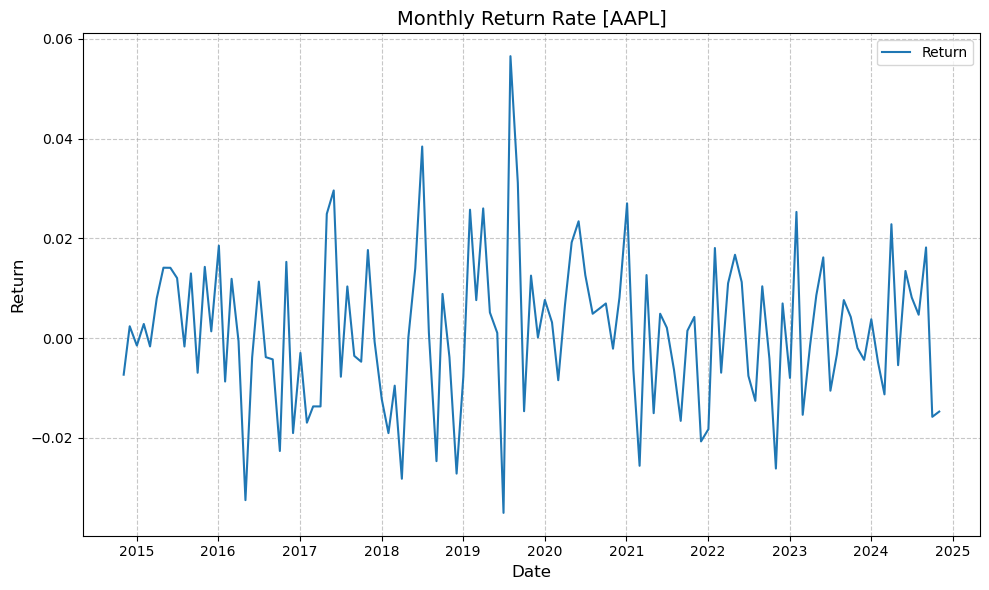

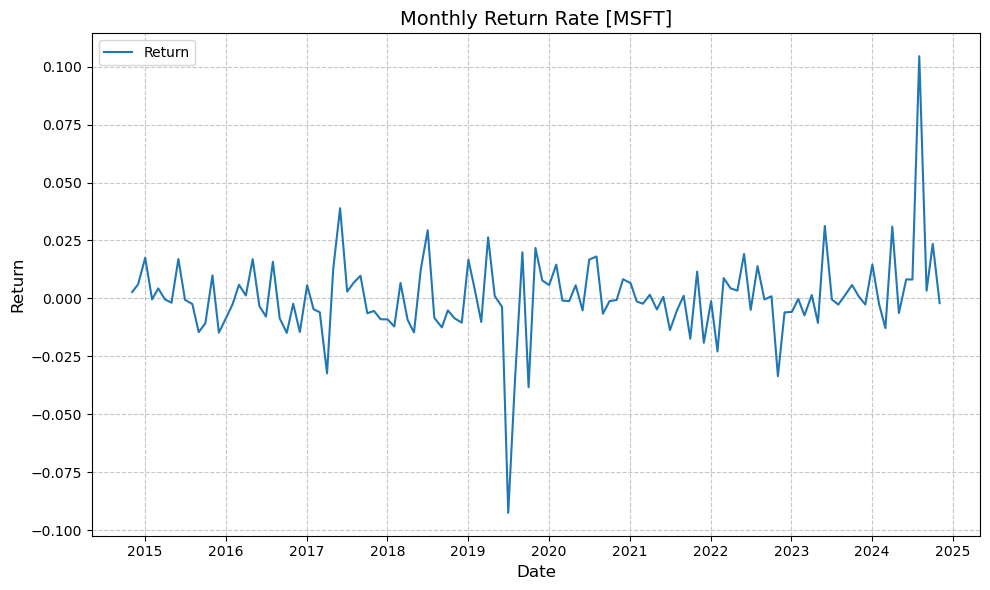

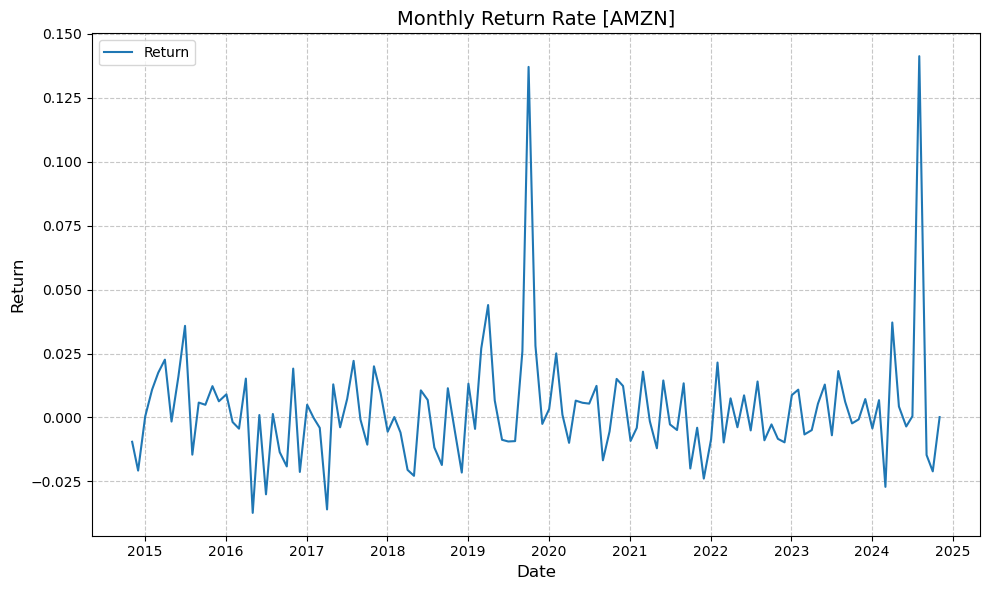

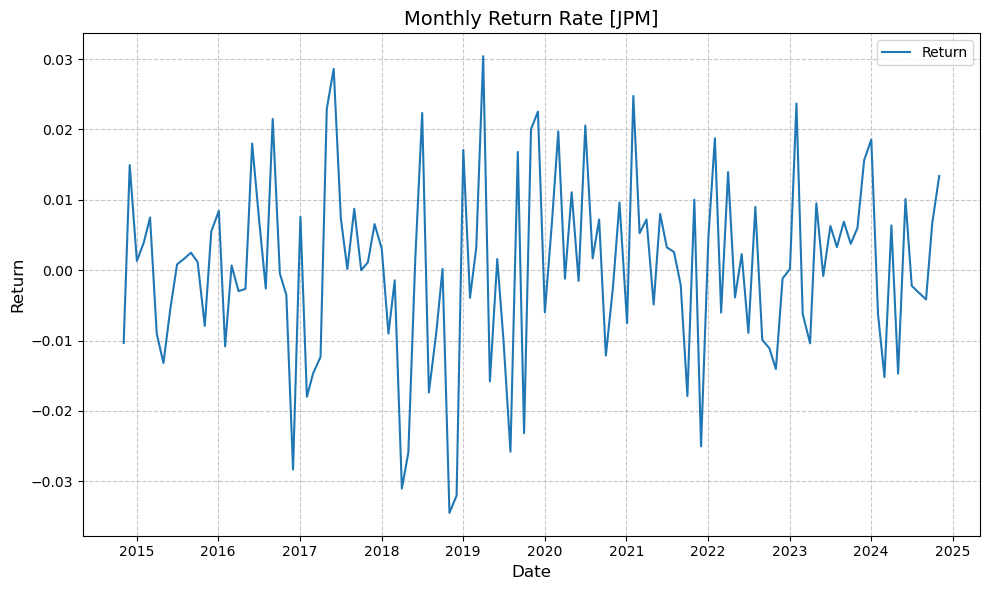

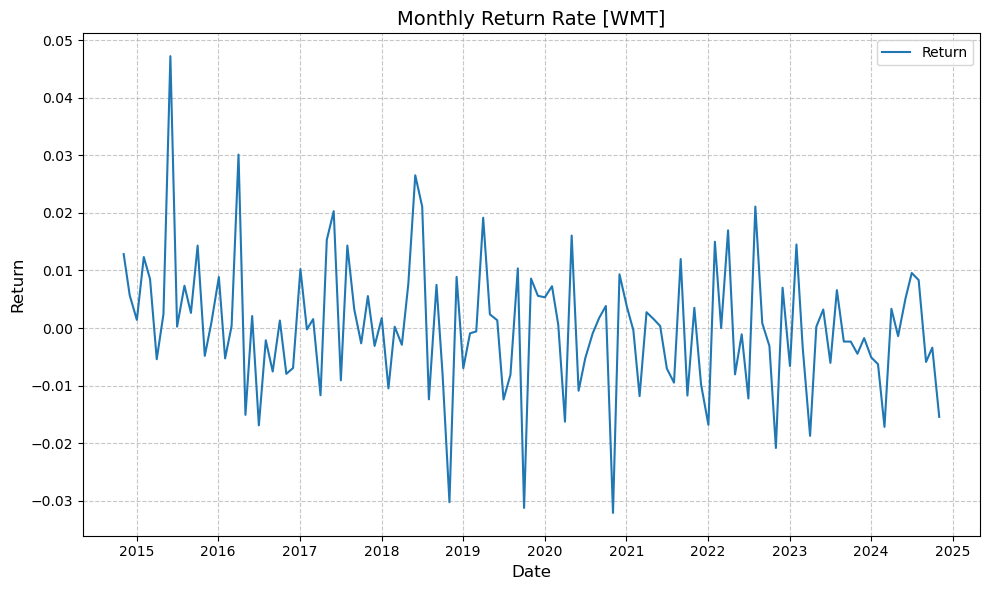

In [152]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in monthly_ret_rates.items():
    plot_ret_rate(ret, "Monthly Return Rate [" + ticker + "]")